# Project: Creating Customer Segments
## Unsupervised Learning


## Intro

I analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
I begin the data exploration through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. For demonstration purpose, I pick **three** indices of your choice to the `indices` list which will represent the customers to track. Different sets of samples are recommended until you obtain customers that vary significantly from one another.

In [3]:
# Select three indices of your choice you wish to sample from the dataset
indices = [2, 101, 311]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)

# reset_index(drop = False): drop the indeces
samples_mod = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = False)

print ("The mean of the selected dataset:")
display(data.mean())
print ("The median of the selected dataset:")
display(data.median())
print ("Chosen samples of wholesale customers dataset:")
#display(samples)
display(samples_mod)

The mean of the selected dataset:


Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

The median of the selected dataset:


Fresh               8504.0
Milk                3627.0
Grocery             4755.5
Frozen              1526.0
Detergents_Paper     816.5
Delicatessen         965.5
dtype: float64

Chosen samples of wholesale customers dataset:


,index,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,6353,8808,7684,2405,3516,7844
1,101,1420,10810,16267,1593,6766,1838
2,311,29635,2335,8280,3046,371,117


### Discussion (Domain Knowledge)
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Note:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

The statistical description of the wholesale distributor:
  
Median:  
- Fresh               8504.0
- Milk                3627.0
- Grocery             4755.5
- Frozen              1526.0
- Detergents_Paper     816.5
- Delicatessen         965.5
  
Average:  
- Fresh               12000.2
- Milk                 5796.2
- Grocery              7951.2
- Frozen               3071.9
- Detergents_Paper     2881.4
- Delicatessen         1524.8

First customer(index=2) consumes 8808 units in Milk, which is larger than the average 5796 and median 3627 of entire dataset. It also consumes lots of Grocery and Detergents_Paper items, comparing to 4755 and 816 units in median, respectively. Moreover, it buys 7844 in Delicatessen, which is above 75% consumption among others. This sample customer might be a deli store because of the huge expense in delicatessen, milk, and grocery items.  

Second customer(index=101) buys lots of milk, grocery, and detergents_paper. The grocery expense is above 75% among other customers. On the other hand, they spend 1420 on fresh items, which is below 25% of entire dataset. Moreover, the expense is in general larger than the average, indicating the size of the store. I would guess second customer is a middle size grocery store. 

Thrid customer(index=311) spends noticeble amount in fresh category, where 29635 is above 75% of entire dataset. It consumes 8280 units for grocery items, which is slightly above the average. They buy very little in detergents paper and delicatessen items. I think it is a restaurant, who prepares food from fresh and grocery items.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

The procedure is as following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.  
   Note: Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [4]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
from sklearn.cross_validation import train_test_split

# import random
# rand_num = random.randint(1, 10)
# print rand_num

#short_list = ['Fresh', 'Milk']

num_of_random_set = 100


for dropped_feature in list(data):
#for dropped_feature in short_list:
    new_data = data.drop(dropped_feature, axis=1)
    predict_this = data[dropped_feature]
    tot_score = []
    for curr_rand_set in range(1, num_of_random_set+1):
        # Split the data into training and testing sets using the given feature as the target
        X_train, X_test, y_train, y_test = train_test_split(new_data, predict_this, test_size=0.25, random_state=curr_rand_set)
        # Create a decision tree regressor and fit it to the training set
        from sklearn.tree import DecisionTreeRegressor
        regressor = DecisionTreeRegressor(random_state=456)
        regressor.fit(X_train, y_train)
        # Report the score of the prediction using the testing set
        score = regressor.score(X_test, y_test)
        tot_score.append(score)
        #print "Score of {:20} is {:8.4f} ".format(dropped_feature, score)
    #print sum(tot_score) / float(len(tot_score))
    print ("Score of {:20} is {:8.4f} ".format(dropped_feature, sum(tot_score) / float(len(tot_score))))

/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Score of Fresh                is  -0.6470 
Score of Milk                 is   0.1814 
Score of Grocery              is   0.6856 
Score of Frozen               is  -1.3450 
Score of Detergents_Paper     is   0.6916 
Score of Delicatessen         is  -2.5954 


### Discussion of the Feature Importance
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Note:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

I pick "Fresh" as my prediction and -0.647 is the prediction score if we drop this feature. The negative $R^2$ value indicates that dropping this feature ("Fresh") gives the bad prediction using the remaining features. In other word, the feature "Fresh" is necessary for identifying customers' spending habits. Due to the remaining high score of dropping Grocery and Detergents_paper, these features are least necessary.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

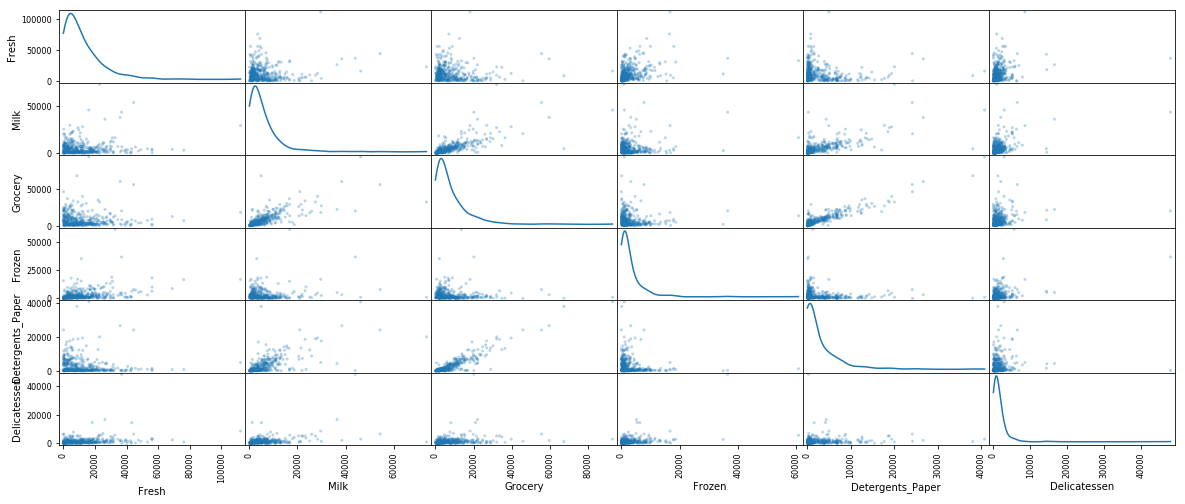

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (20,8), diagonal = 'kde');

                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000  0.100510 -0.011854  0.345881         -0.101953   
Milk              0.100510  1.000000  0.728335  0.123994          0.661816   
Grocery          -0.011854  0.728335  1.000000 -0.040193          0.924641   
Frozen            0.345881  0.123994 -0.040193  1.000000         -0.131525   
Detergents_Paper -0.101953  0.661816  0.924641 -0.131525          1.000000   
Delicatessen      0.244690  0.406368  0.205497  0.390947          0.069291   

                  Delicatessen  
Fresh                 0.244690  
Milk                  0.406368  
Grocery               0.205497  
Frozen                0.390947  
Detergents_Paper      0.069291  
Delicatessen          1.000000  
['Fre', 'Mil', 'Gro', 'Fro', 'Det', 'Del']


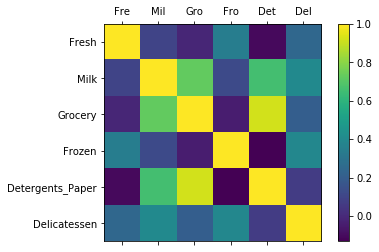

In [6]:
print (data.corr())
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr())
fig.colorbar(cax)

my_list_abbre = [i[0:3] for i in data]

print (my_list_abbre)
ax.set_xticklabels(['']+my_list_abbre)
ax.set_yticklabels(['']+list(data))

plt.show()


### Discussion (Degree of Correlation)
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Note:** Is the data normally distributed? Where do most of the data points lie? 

Grocery and detergents_paper show the strong correlation. Milk has a mild correlation to grocery and detergents paper. The correlation between fresh to other features is very limited, showing that fresh is necessary to identify customers' behavior. The result confirms my suspicions about the relevance of the feature. The diagonal of scatter_matrix plot represents the density distribution of the corresponding feature. Most data points lie at the left  of the figure, indicating the positve skew or right-skewed distribution. It also suggests the data normalization.


## Data Preprocessing
Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, the procedure is as following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

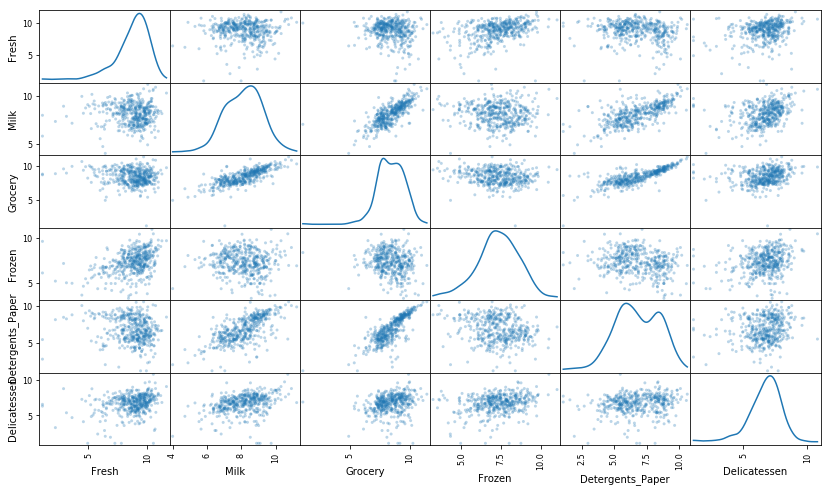

In [7]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [8]:
# Display the log-transformed sample data
display(log_samples)

display(log_data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
1,7.258412,9.288227,9.696894,7.373374,8.819665,7.516433
2,10.296711,7.755767,9.021598,8.021585,5.916202,4.762174


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

The procedure is as following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [9]:
# For each feature find the data points with extreme high or low values

out_dc = {}

for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    ## print ("Data points considered outliers for the feature '{}':".format(feature))
    ## display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
     
    #save the index of outliers in each category    
    i, = np.where( ~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))==True )
    #print list(i)

    #save numpy.array to list and add into dictionary at each key value (feature)
    out_dc[feature] = list(i)   

#print out_dc

outliers = []

# val represents each list
for category, val in out_dc.items():
    print (category,val)
    outliers += val

freq_outliers = sorted(set([x for x in outliers if outliers.count(x) > 1]))

print(freq_outliers)

print ("These outliers are observed in more than one feature: {}".format(freq_outliers))    
        
# OPTIONAL: Select the indices for data points you wish to remove
# use set() to remove the same indices

# outliers = sorted(set(outliers)) 

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[freq_outliers]).reset_index(drop = True)

Fresh [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412]
Milk [86, 98, 154, 356]
Grocery [75, 154]
Frozen [38, 57, 65, 145, 175, 264, 325, 420, 429, 439]
Detergents_Paper [75, 161]
Delicatessen [66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]
[65, 66, 75, 128, 154]
These outliers are observed in more than one feature: [65, 66, 75, 128, 154]


### Discussion on Outliers
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed* 

**Thought:** Yes, the items with index 65, 66, 75, 128, 154 from original list of dataset are considered outliers for more than one feature with previous definition. I would remove these data points because these might not well represent the entire dataset. In general, it is the best practice to capture the tendency accurately (hopefully) without the effect from these outliers. As stated [here](http://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/), outlier affects both results and assumptions so that the comparison should be performed to show the difference.

## Feature Transformation
I use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


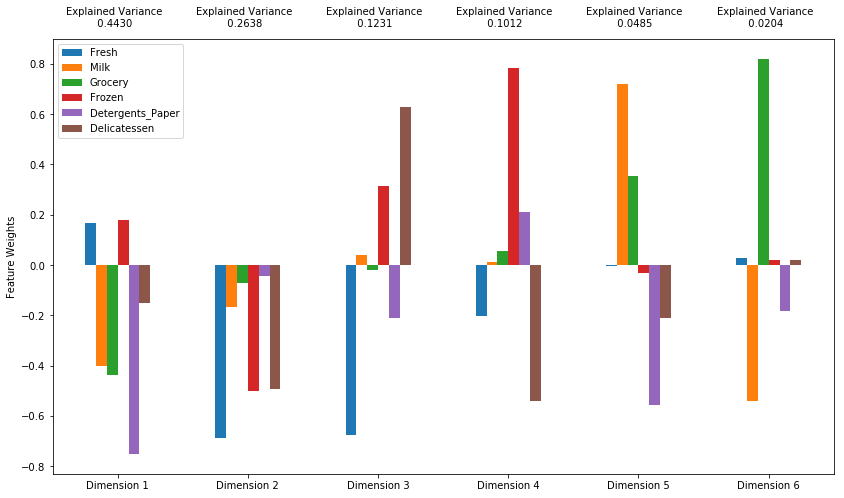

In [10]:
from sklearn.decomposition import PCA
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)
# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

print (pca_results['Explained Variance'].cumsum())


### Discussion on Explained Variance  
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Note:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

0.7068 is explained in total by the first and second principal component. 0.9311 is explained in total by the first four principal components. Detergents_paper, grocery, and milk are the three most weighted features in first principal component. This obervation is consistent with the score in *Feature Relevance* section that these features are correlated to each other. Not surprisingly, the remaining features (fresh, frozen, and delicatessen) are more weighted in second principal component, which are orthorgonal to the ones in first principal component in its feature space. Delicatessen and frozen are best represent in terms of customer spending in third and fourth dimension, respectively. In conclusion, we see that the first principal component correlates most strongly with the Detergents_paper, moderately with Grocery and Milk. It suggests first principal component would tend to identify the supermarket or grocery story customer. Second principal component would tend to identify the restaurant business with three top most correlated features, Fresh, frozen, and Deli. Third principal component would better decribe the foodstand customer with large positive correlation with Deli and large negative correlation with Fresh. Fourth principal component would predict frozen food distributor type of business.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [11]:
display(samples_mod)

# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,index,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,6353,8808,7684,2405,3516,7844
1,101,1420,10810,16267,1593,6766,1838
2,311,29635,2335,8280,3046,371,117


,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.8834,-1.5991,1.3204,-0.5432,-0.3934,-0.3117
1,-2.8929,0.2367,1.1485,0.4079,-0.0238,-0.0071
2,1.2370,-0.3835,-1.8704,1.1242,0.8014,0.8437


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [16]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)
# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

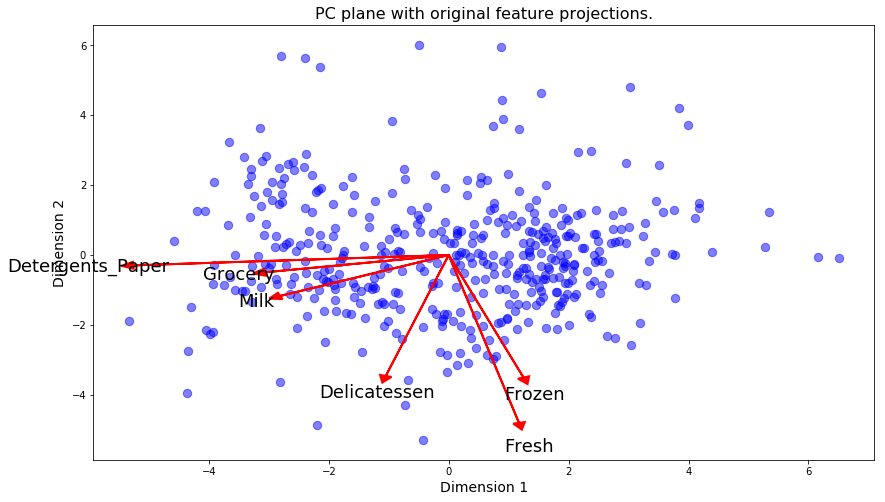

In [17]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

**Note:** Detergents_paper, grocery, and milk are most strongly correlated with the first component. Fresh, frozen, and deli are associated with the second component. Yes. These two observation agree with the pca_results plot.  

## Clustering

In this section, we could choose either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. Moreover, one could recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Discussion on Clustering Algorithm
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Thought:**  

The advantages of K-Means clustering algorithm:
 - Running time
 - Suitable for high dimensional data
 - Easy to interpret

The advantages of Gaussian Mixture Model clustering algorithm:
 - Work well with non-linear geometric distribution
 - Allow non-circular cluster structure

The major difference between two approaches is that K-means provides hard assignment, where particular points belong to determined group, but Gaussian Mixture model gives the possibility of data points belonging to a cluster. For now, I would try K-means method for simplicity, and try Gaussian Mixture Model as comparison. 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

Number of cluster:  2, Your silhouette_score is   0.4263
Number of cluster:  3, Your silhouette_score is   0.3969
Number of cluster:  4, Your silhouette_score is   0.3305
Number of cluster:  5, Your silhouette_score is   0.3510
Number of cluster:  6, Your silhouette_score is   0.3615
Number of cluster:  7, Your silhouette_score is   0.3649
Number of cluster:  8, Your silhouette_score is   0.3472
Number of cluster:  9, Your silhouette_score is   0.3637
Number of cluster: 10, Your silhouette_score is   0.3482


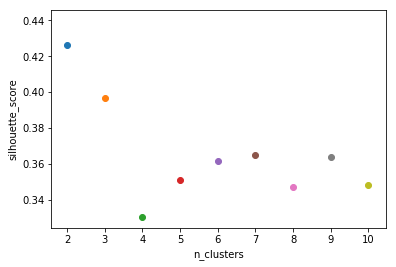

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def kmeans_silhouette_score(num_of_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=num_of_clusters, random_state=123).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    return score, preds, sample_preds, centers
    
for num_of_clusters in range(2,11):
    score, _, _, _  = kmeans_silhouette_score(num_of_clusters)
    print ("Number of cluster: {:2.0f}, Your silhouette_score is {:8.4f}".format(num_of_clusters, score))
    plt.scatter(num_of_clusters, score)
plt.xlabel('n_clusters')
plt.ylabel('silhouette_score')
plt.show()

**Note:** While there are 2 clusters, the Kmeans method reaches its highest silhouette score (0.4263).

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

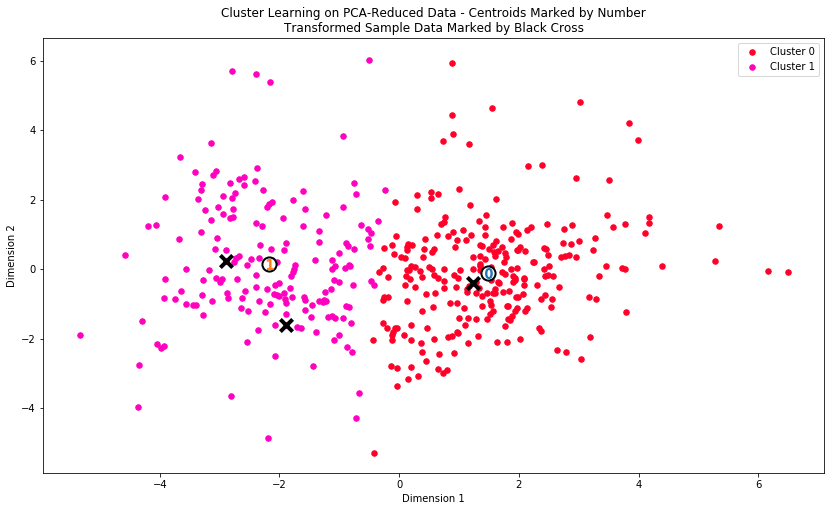

In [21]:
score, preds, sample_preds, centers = kmeans_silhouette_score(2)
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [22]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments

print (" --------- Original Segment ---------")
display(true_centers)

print (" --------- Segment subtracts median ---------")
data_dropped_outliers = data.drop(log_data.index[freq_outliers]).reset_index(drop = True)
display(true_centers-np.around(data_dropped_outliers.median().values))


 --------- Original Segment ---------


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


 --------- Segment subtracts median ---------


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,302.0,-1737.0,-2280.0,547.0,-519.0,-286.0
Segment 1,-4560.0,4266.0,7347.0,-589.0,3748.0,69.0


### Discussion on Clustering
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Note:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Thought:** For segment 0 and 1, most values in each category are smaller than its average so that the comparison isn't clear. The very small or large numbers play an important role such that I would rather make the comparison by median. One can observe that segment 0 spends more on the category Fresh and Frozen. On the other hand, most of the expense by segment 1 are in category of Milk, Grocery, Detergents_paper, and Deli. With that, I would conclude that Cluster 0 should be best identify as restaurant or foodstand where serves food for customers and Cluster 1 should be grocery store or supermarket type of business. 

### Which segment sample point belongs to?
*For each sample point, which customer segment best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [23]:
# Before the prediction, we make our naive guess of each sample 
#display(true_centers)
#display(samples)

display(true_centers-np.around(data_dropped_outliers.median().values))
display(samples-np.around(data_dropped_outliers.median().values))


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,302.0,-1737.0,-2280.0,547.0,-519.0,-286.0
Segment 1,-4560.0,4266.0,7347.0,-589.0,3748.0,69.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-2212.0,5174.0,2927.0,864.0,2703.0,6877.0
1,-7145.0,7176.0,11510.0,52.0,5953.0,871.0
2,21070.0,-1299.0,3523.0,1505.0,-442.0,-850.0


Because it is hard to guess which segment the sample belongs to by directly comparing the absolute value, we subtract the median for true center and sample sets. By doing so, we observe that the first and second samples behave very similar that they consume less in Fresh and large in Milk and Grocery and Detergents_Papers. I would guess first and second samples belong to Segment 1. On the otherhand, the third sample customer buys great amount in Fresh and little in Milk and Detergents_paper, where it should belong to Segment 0.

In [25]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Thought:**  

The kmeans clustering algorithm suggests:
- Sample point 0 predicted to be in Cluster 1
- Sample point 1 predicted to be in Cluster 1
- Sample point 2 predicted to be in Cluster 0    

The predictions fit very well with our intuition, where first and second samples belongs cluster 1 and third belongs cluster 0. We have suggested that Cluster 0 should be best identify as restaurant and Cluster 1 should be grocery store type of business. Furthermore, the above predictions are consistent with the answers in Question 1.

* First customer(index=2) might be a deli store.  
* Second customer(index=101) might be a grocery store.  
* Thrid customer(index=311) might be a restaurant.


## Conclusion

In this final section, I focus on how we can make use of the clustered data. First, I consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, I analyze how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, I compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Business Strategy
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Note:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Thought:** We should not assume that the changes affects all customers equally. I think for coffee shop type business (Cluster 0), 5 days a week to 3 days a week delivery service should have a positive effect where they require freshness of the selling items more significantly. For supermarket (Cluster 1), 5 days a week might be better than 3 days a week delivery service due to the selling strategy and logistics. The owner should be able to manage the business effectively with 5 days/week delivery, focusing on the customer but not the logistics.
The idea of introducing new delivery time period can be evaluated through A/B test, where one variation of two groups might affect a user's behavior. More importantly, as stated in [Wiki](https://en.wikipedia.org/wiki/A/B_testing#An_emailing_campaign_example), "An A/B test should have a **defined outcome that is measurable**".  
A/B testing for our case is to change the delivery service for each cluster as experimental group, and the original delivery service as control group. The idea is to determine which of the two variables is more effective, or identifying which cluster has changed more significantly. It is worth to emphasize that few but statistically significant samples are introduced by new delivery service in both category, to see cluster 1 or cluster 2 has more prominent effect.

### New Coming Data
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Thought:** Using the estimates for anticipated annual spending of each product category, each new customer can be predicted being in group segment 0 or 1 (for 2 clusters). The customer segment is the target variable using in supervised learning.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

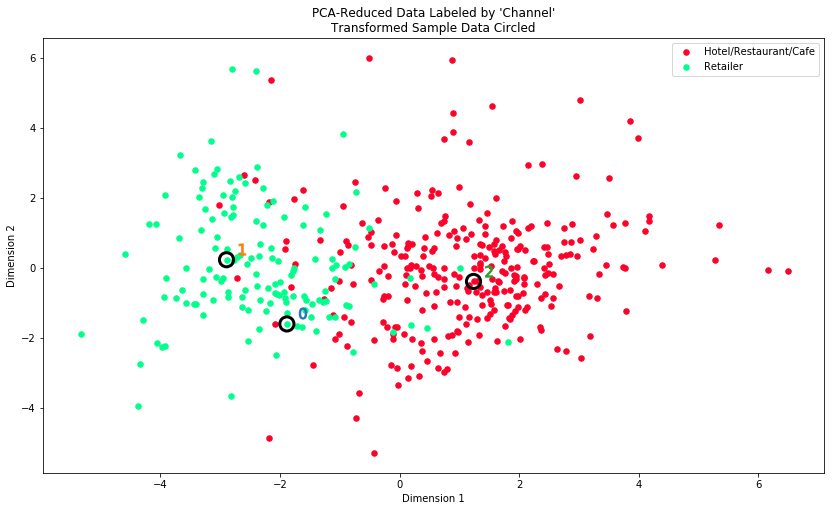

In [26]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, freq_outliers, pca_samples)

### Final Remark
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Thought:** I think the applied clustering is in agreement with our prediction and intuition. Even though few data points exist at the overlapping area between multiple clusters, the algorithm still provide representative clustering. The first and second examples, where we identify as deli and grocery store, are predicted as retailer. The third customer, where we identify as a restaurant, is predicted in Hotel/Restaurant/Cafe category.